# Teleconnections between ENSO and individual countries
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import signal, stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

Data locations

In [2]:
loc_shp = "../Data/ProcessedCountryShapefile/"
loc_panel = "../Data/Panel/"
loc_enso = "../Data/ENSO_Indices/"
loc_country_temp = "../Data/CountryTemp/"
loc_country_precip = "../Data/CountryPrecip/"
loc_out = "../Data/Teleconnections/"

Years

In [3]:
y1_enso = 1960
y2_enso = 2019
y1_final = 1960
y2_final = 2019

Read shapefile

In [4]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values

#### Analysis

Load data

In [5]:
enso_in = xr.open_dataset(loc_enso+"obs_ENSO_indices_monthly_"+str(y1_enso)+"-"+str(y2_enso)+".nc")
e_monthly = enso_in.e_index
c_monthly = enso_in.c_index

Annual ENSO

In [6]:
def monthly_to_yearly_mean(x):

        # calculate annual mean from monthly data
        # after weighting for the difference in month length
        # x must be data-array with time coord
        # xarray must be installed

        # x_yr = x.resample(time="YS").mean(dim="time") is wrong
        # because it doesn't weight for the # of days in each month

        days_in_mon = x.time.dt.days_in_month
        wgts = days_in_mon.groupby("time.year")/days_in_mon.groupby("time.year").sum()
        ones = xr.where(x.isnull(),0.0,1.0)
        x_sum = (x*wgts).resample(time="YS").sum(dim="time")
        ones_out = (ones*wgts).resample(time="YS").sum(dim="time")
        return(x_sum/ones_out)

In [7]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning,message="'base' in .resample()")

In [8]:
enso_time_ind = (e_monthly.time.dt.year>=y1_final)&(e_monthly.time.dt.year<=y2_final)
Eshift = e_monthly[enso_time_ind].shift(time=1)
Eshift.coords["time"] = pd.date_range(start=str(y1_final)+"-01-01",end=str(y2_final)+"-12-31",freq="MS")
E_yr = monthly_to_yearly_mean(Eshift[Eshift.time.dt.month<=3])
Cshift = c_monthly[enso_time_ind].shift(time=1)
Cshift.coords["time"] = pd.date_range(start=str(y1_final)+"-01-01",end=str(y2_final)+"-12-31",freq="MS")
C_yr = monthly_to_yearly_mean(Cshift[Cshift.time.dt.month<=3])

Monthly mean country temps and precip

In [11]:
y1_temp = 1900
y2_temp = 2019
country_temp_monthly = xr.open_dataarray(loc_country_temp+"BerkeleyEarth_country_temp_monthly_std_"+str(y1_temp)+"-"+str(y2_temp)+".nc")
country_temp = country_temp_monthly.loc[:,str(y1_final)+"-01-01":str(y2_final)+"-12-31"]

y1_precip = 1900
y2_precip = 2019
country_precip_monthly = xr.open_dataarray(loc_country_precip+"GPCC_country_precip_monthly_std_"+str(y1_precip)+"-"+str(y2_precip)+".nc")
country_precip = country_precip_monthly.loc[:,str(y1_final)+"-01-01":str(y2_final)+"-12-31"]

Regression for each country

In [12]:
iso = country_temp.iso.values
from statsmodels.formula.api import ols as reg

In [13]:
# june through august -- summer season in both directions
mons = [-6,-7,-8,-9,-10,-11,-12,1,2,3,4,5,6,7,8] #-5 ,7,8,9,10,11,12]
# (-) means year t, (+) means year t+1
inds = ["e","c"]

In [14]:
temp_coefs = xr.DataArray(np.full((len(inds),len(iso),len(mons)),np.nan),
                         coords=[inds,iso,mons],dims=["index","iso","month"])
precip_coefs = xr.DataArray(np.full((len(inds),len(iso),len(mons)),np.nan),
                         coords=[inds,iso,mons],dims=["index","iso","month"])
temp_regcoefs = xr.DataArray(np.full((len(inds),len(iso),len(mons)),np.nan),
                         coords=[inds,iso,mons],dims=["index","iso","month"])
precip_regcoefs = xr.DataArray(np.full((len(inds),len(iso),len(mons)),np.nan),
                         coords=[inds,iso,mons],dims=["index","iso","month"])
temp_pval = xr.DataArray(np.full((len(inds),len(iso),len(mons)),np.nan),
                         coords=[inds,iso,mons],dims=["index","iso","month"])
precip_pval = xr.DataArray(np.full((len(inds),len(iso),len(mons)),np.nan),
                         coords=[inds,iso,mons],dims=["index","iso","month"])

In [15]:
def partial_correlation(x,y,z):
    from statsmodels.formula.api import ols as reg
    df = pd.DataFrame({"x":x,"y":y,"z":z})
    x_z_resids = reg("x~z",data=df).fit().resid.values
    y_z_resids = reg("y~z",data=df).fit().resid.values
    corr, p = stats.pearsonr(x_z_resids,y_z_resids)
    return([corr,p])

In [16]:
for e in np.arange(0,len(inds),1):
    ind = inds[e]
    print(ind)
    if ind == "e":
        enso = E_yr
    else:
        enso = C_yr
    for i in np.arange(0,len(iso),1):
        if np.mod(i,20)==0:
            print(i)
        for m in np.arange(0,len(mons),1):
            enso_final = enso[1:]
            if mons[m]<0:
                t = country_temp[i,country_temp.time.dt.month==np.abs(mons[m])].shift(time=1)[1:]
                p = country_precip[i,country_precip.time.dt.month==np.abs(mons[m])].shift(time=1)[1:]
            else:
                t = country_temp[i,country_temp.time.dt.month==mons[m]][1:]
                p = country_precip[i,country_precip.time.dt.month==mons[m]][1:]
            if (~np.any(np.isnan(t))) & (~np.any(np.isnan(p))):
                t_dt = signal.detrend(t,type="linear")
                p_dt = signal.detrend(p,type="linear")
                df = pd.DataFrame({"t":t_dt,"p":p_dt,"enso":enso_final.values})
                temp_coefs[e,i,m], temp_pval[e,i,m] = partial_correlation(enso_final,t_dt,p_dt)
                precip_coefs[e,i,m], precip_pval[e,i,m] = partial_correlation(enso_final,p_dt,t_dt)
                
                # regression coefficients too, not just correlation coefficients 
                temp_regcoefs[e,i,m] = reg("t ~ enso + p",data=df).fit().params["enso"]
                precip_regcoefs[e,i,m] = reg("p ~ enso + t",data=df).fit().params["enso"]

e
0
20
40
60
80
100
120
140
160
c
0
20
40
60
80
100
120
140
160


In [17]:
t_coefs_max = np.abs(temp_coefs).max(dim="month")
p_coefs_max = np.abs(precip_coefs).max(dim="month")
combined_teleconnection_e = p_coefs_max.loc["e",:] + t_coefs_max.loc["e",:]
combined_teleconnection_c = p_coefs_max.loc["c",:] + t_coefs_max.loc["c",:]
t_regcoefs_max = np.abs(temp_regcoefs).max(dim="month")
p_regcoefs_max = np.abs(precip_regcoefs).max(dim="month")
combined_reg_teleconnection_e = t_regcoefs_max.loc["e",:] + p_regcoefs_max.loc["e",:]
combined_reg_teleconnection_c = t_regcoefs_max.loc["c",:] + p_regcoefs_max.loc["c",:]

# running mean
t_coefs_max_running3 = np.abs(temp_regcoefs).rolling(month=3).mean().max(dim="month")
p_coefs_max_running3 = np.abs(precip_regcoefs).rolling(month=3).mean().max(dim="month")
tc_e_running3 = p_coefs_max_running3.loc["e",:] + t_coefs_max_running3.loc["e",:]
tc_c_running3 = p_coefs_max_running3.loc["c",:] + t_coefs_max_running3.loc["c",:]

# running mean corr coef
t_corrcoefs_max_running3 = np.abs(temp_coefs).rolling(month=3).mean().max(dim="month")
p_corrcoefs_max_running3 = np.abs(precip_coefs).rolling(month=3).mean().max(dim="month")
tc_e_corr_running3 = p_corrcoefs_max_running3.loc["e",:] + t_corrcoefs_max_running3.loc["e",:]
tc_c_corr_running3 = p_corrcoefs_max_running3.loc["c",:] + t_corrcoefs_max_running3.loc["c",:]

# cumulative
t_corrcoefs_sum_running3 = np.abs(temp_coefs).rolling(month=3).mean().sum(dim="month")
p_corrcoefs_sum_running3 = np.abs(precip_coefs).rolling(month=3).mean().sum(dim="month")
t_corrcoefs_sum_running3 = t_corrcoefs_sum_running3.where(t_corrcoefs_sum_running3>0)
p_corrcoefs_sum_running3 = p_corrcoefs_sum_running3.where(p_corrcoefs_sum_running3>0)
tc_e_corr_sum = p_corrcoefs_sum_running3.loc["e",:] + t_corrcoefs_sum_running3.loc["e",:]
tc_c_corr_sum = p_corrcoefs_sum_running3.loc["c",:] + t_corrcoefs_sum_running3.loc["c",:]

# cumulative reg coef
t_regcoefs_sum_running3 = np.abs(temp_regcoefs).rolling(month=3).mean().sum(dim="month")
p_regcoefs_sum_running3 = np.abs(precip_regcoefs).rolling(month=3).mean().sum(dim="month")
t_regcoefs_sum_running3 = t_regcoefs_sum_running3.where(t_regcoefs_sum_running3>0)
p_regcoefs_sum_running3 = p_regcoefs_sum_running3.where(p_regcoefs_sum_running3>0)
tc_e_reg_sum = p_regcoefs_sum_running3.loc["e",:] + t_regcoefs_sum_running3.loc["e",:]
tc_c_reg_sum = p_regcoefs_sum_running3.loc["c",:] + t_regcoefs_sum_running3.loc["c",:]

Sum only when the coefficients are significant

In [18]:
alpha = 0.05
t_coef_sum_sig = np.abs(temp_coefs).where(temp_pval<alpha,np.nan).sum(dim="month")
#t_coef_sum_sig = t_coef_sum_sig.where(t_coef_sum_sig>0)
p_coef_sum_sig = np.abs(precip_coefs).where(precip_pval<alpha,np.nan).sum(dim="month")
#p_coef_sum_sig = p_coef_sum_sig.where(p_coef_sum_sig>0)
tc_e_corr_sum_sig = t_coef_sum_sig.loc["e",:] + p_coef_sum_sig.loc["e",:]
tc_c_corr_sum_sig = t_coef_sum_sig.loc["c",:] + p_coef_sum_sig.loc["c",:]

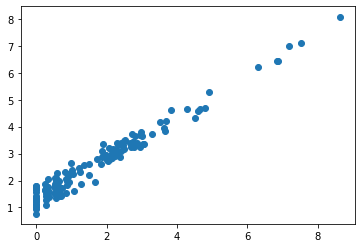

In [19]:
plt.scatter(t_coef_sum_sig.sel(index="e"),t_corrcoefs_sum_running3.sel(index="e"))

In [20]:
ind = (~np.isnan(t_coef_sum_sig.sel(index="e")))&(~np.isnan(t_corrcoefs_sum_running3.sel(index="e")))
stats.spearmanr(t_coef_sum_sig.sel(index="e")[ind],t_corrcoefs_sum_running3.sel(index="e")[ind])

SpearmanrResult(correlation=0.915415620032299, pvalue=2.4801913664491146e-64)

In [21]:
stats.spearmanr(tc_e_corr_running3[~np.isnan(tc_e_corr_running3)],tc_e_corr_sum[~np.isnan(tc_e_corr_sum)])

SpearmanrResult(correlation=0.9252461033634126, pvalue=2.1217731567987633e-68)

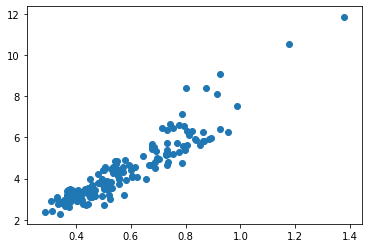

In [22]:
plt.scatter(tc_e_corr_running3,tc_e_corr_sum)

In [23]:
stats.spearmanr(tc_e_corr_running3[~np.isnan(tc_e_corr_running3)],tc_e_corr_sum_sig[~np.isnan(tc_e_corr_running3)])

SpearmanrResult(correlation=0.9348561123110273, pvalue=5.916356983785465e-73)

In [24]:
combined_reg_teleconnection_e.loc[["PER","ECU","CAN","RUS","AUS","IDN"]]

<xarray.DataArray (iso: 6)>
array([1.8229598 , 2.02384597, 0.72741461, 0.50312674, 0.60083136,
       1.02740467])
Coordinates:
    index    <U1 'e'
  * iso      (iso) object 'PER' 'ECU' 'CAN' 'RUS' 'AUS' 'IDN'

In [25]:
tc_e_corr_running3.loc[["PER","ECU","CAN","RUS","AUS","IDN"]]

<xarray.DataArray (iso: 6)>
array([1.17716659, 1.37822822, 0.49671001, 0.35622375, 0.41804235,
       0.98897624])
Coordinates:
    index    <U1 'e'
  * iso      (iso) object 'PER' 'ECU' 'CAN' 'RUS' 'AUS' 'IDN'

Now we want the "maximum" precip correlation, but we want to allow the sign to be either positive or negative -- to distinguish between countries that get drier and wetter during El Nino

In [26]:
p_coefs_origsign = xr.DataArray(np.full((len(inds),len(iso)),np.nan),
                         coords=[inds,iso],dims=["index","iso"])

for e in np.arange(0,len(inds),1):
    ind = inds[e]
    print(ind)
    for i in np.arange(0,len(iso),1):
        p_coefs = precip_coefs[e,i,:]
        p_coefs_rolling = p_coefs.rolling(month=3).mean()
        p_coefs_abs = np.abs(p_coefs_rolling.values)
        if ~np.all(np.isnan(p_coefs_abs)):
            p_coefs_origsign[e,i] = p_coefs_rolling[np.nanargmax(p_coefs_abs)]
            #p_coefs_origsign[e,i] = p_coefs_rolling.sum().values

e
c


Write out T correlation, P correlation, and their sum

In [27]:
desc =  "t_pval_e: pvalue of each month of e-t correlation; "\
        "p_pval_e: pvalue of each month of e-p correlation; "\
        "t_pval_c: pvalue of each month of c-t correlation; "\
        "p_pval_c: pvalue of each month of c-p correlation; "\
        "p_corr2_e: cumulative e-p partial correlation, sign preserved; "\
        "p_corr2_c: cumulative c-p partial correlation, sign preserved; "\
        "t_corr_running_e: max monthly e-t partial correlation, running mean; "\
        "p_corr_running_e: max monthly e-p partial correlation, running mean; "\
        "t_corr_running_c: max monthly c-t partial correlation, running mean; "\
        "p_corr_running_c: max monthly c-p partial correlation, running mean; "\
        "combined_corr_e: sum of correlations, e-index;"\
        "combined_corr_c: sum of correlations, c-index;"\
        "combined_reg_e: sum of regression coefficients, e-index;"\
        "combined_reg_c: sum of regression coefficients, c-index;"\
        "combined_corr_e_running: sum of running mean correlation coefficients, e-index;"\
        "combined_corr_c_running: sum of running mean correlation coefficients, c-index;"\
        "combined_reg_e_running: sum of running mean regression coefficients, e-index;"\
        "combined_reg_c_running: sum of running mean regression coefficients, c-index;"\
        "combined_corr_e_sum: sum of cumulative running mean correlation coefficients, e-index;"\
        "combined_corr_c_sum: sum of cumulative running mean correlation coefficients, c-index;"\
        "combined_reg_e_sum: sum of cumulative running mean regression coefficients, e-index;"\
        "combined_reg_c_sum: sum of cumulative running mean regression coefficients, c-index;"\
        "t_corr_e_sum: temp-only cumulative running mean correlation coefficients, e-index;"\
        "p_corr_e_sum: precip-only cumulative running mean correlation coefficients, e-index;"\
        "t_corr_c_sum: temp-only cumulative running mean correlation coefficients, c-index;"\
        "p_corr_c_sum: precip-only cumulative running mean correlation coefficients, c-index;"\
        "combined_corr_e_sum_sig: sum of only significant correlation coefficients, e-index;"\
        "combined_corr_c_sum_sig: sum of only significant correlation coefficients, c-index"


ds = xr.Dataset({"t_pval_e":(["iso","month"],temp_pval.loc["e",:,:]),
                "p_pval_e":(["iso","month"],precip_pval.loc["e",:,:]),
                "t_pval_c":(["iso","month"],temp_pval.loc["c",:,:]),
                "p_pval_c":(["iso","month"],precip_pval.loc["c",:,:]),
                "p_corr2_e":(["iso"],p_coefs_origsign.loc["e",:]),
                "p_corr2_c":(["iso"],p_coefs_origsign.loc["c",:]),
                "t_corr_running_e":(["iso"],t_corrcoefs_max_running3.loc["e",:]),
                "p_corr_running_e":(["iso"],p_corrcoefs_max_running3.loc["e",:]),
                "t_corr_running_c":(["iso"],t_corrcoefs_max_running3.loc["c",:]),
                "p_corr_running_c":(["iso"],p_corrcoefs_max_running3.loc["c",:]),
                "combined_corr_e":(["iso"],combined_teleconnection_e),
                "combined_corr_c":(["iso"],combined_teleconnection_c),
                "combined_reg_e":(["iso"],combined_reg_teleconnection_e),
                "combined_reg_c":(["iso"],combined_reg_teleconnection_c),
                "combined_corr_e_running":(["iso"],tc_e_corr_running3),
                "combined_corr_c_running":(["iso"],tc_c_corr_running3),
                "combined_reg_e_running":(["iso"],tc_e_running3),
                "combined_reg_c_running":(["iso"],tc_c_running3),
                "combined_corr_e_sum":(["iso"],tc_e_corr_sum),
                "combined_corr_c_sum":(["iso"],tc_c_corr_sum),
                "combined_reg_e_sum":(["iso"],tc_e_reg_sum),
                "combined_reg_c_sum":(["iso"],tc_c_reg_sum),
                "t_corr_e_sum":(["iso"],t_corrcoefs_sum_running3.loc["e",:]),
                "p_corr_e_sum":(["iso"],p_corrcoefs_sum_running3.loc["e",:]),
                "t_corr_c_sum":(["iso"],t_corrcoefs_sum_running3.loc["c",:]),
                "p_corr_c_sum":(["iso"],p_corrcoefs_sum_running3.loc["c",:]),
                "combined_corr_e_sum_sig":(["iso"],tc_e_corr_sum_sig),
                "combined_corr_c_sum_sig":(["iso"],tc_c_corr_sum_sig)},
               coords={"iso":(["iso"],t_coefs_max.iso),
                      "month":(["month"],temp_pval.month)})

ds.attrs["creation_date"] = str(datetime.datetime.now())
ds.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
ds.attrs["variable_description"] = desc
ds.attrs["created_from"] = os.getcwd()+"/Observed_Teleconnections.ipynb"

fname_out = loc_out+"ENSO_observed_teleconnections_DJF_"+str(y1_final)+"-"+str(y2_final)+".nc"
ds.to_netcdf(fname_out,mode="w")
print(fname_out)

../Data/Teleconnections/ENSO_observed_teleconnections_DJF_1960-2019.nc


Now do this in running 30-year windows

In [29]:
y2_window = np.arange(1989,2019+1,1)
len_window = 30

In [30]:
mons = [-6,-7,-8,-9,-10,-11,-12,1,2,3,4,5,6,7,8]
inds = ["e","c"]

calc_window_tc = True

if calc_window_tc == True:
    temp_coefs_windows = xr.DataArray(np.full((len(y2_window),len(inds),len(iso),len(mons)),np.nan),
                             coords=[y2_window,inds,iso,mons],dims=["window","index","iso","month"])
    precip_coefs_windows  = xr.DataArray(np.full((len(y2_window),len(inds),len(iso),len(mons)),np.nan),
                             coords=[y2_window,inds,iso,mons],dims=["window","index","iso","month"])

    tm = np.arange(y1_final,y2_final+1,1)

    for y2_w in y2_window:
        y1_w = y2_w-len_window+1
        print(str(y1_w)+"-"+str(y2_w))
        y2_ind = list(y2_window).index(y2_w)

        for e in np.arange(0,len(inds),1):
            ind = inds[e]
            #print(ind)
            if ind == "e":
                enso = E_yr
            else:
                enso = C_yr
            enso.coords["time"] = tm
            enso_window = enso.loc[y1_w:y2_w]

            for i in np.arange(0,len(iso),1):
                #if np.mod(i,40)==0:
                #    print(i)
                for m in np.arange(0,len(mons),1):
                    if mons[m]<0:
                        t = country_temp[i,country_temp.time.dt.month==np.abs(mons[m])].shift(time=1)
                        p = country_precip[i,country_precip.time.dt.month==np.abs(mons[m])].shift(time=1)
                    else:
                        t = country_temp[i,country_temp.time.dt.month==mons[m]]
                        p = country_precip[i,country_precip.time.dt.month==mons[m]]
                    enso_final = enso_window[1:]
                    p.coords["time"] = p.time.dt.year.values
                    t.coords["time"] = t.time.dt.year.values

                    if (~np.any(np.isnan(t))) & (~np.any(np.isnan(p))):
                        t_dt = signal.detrend(t,type="linear")
                        p_dt = signal.detrend(p,type="linear")
                        t_window = t_dt[(tm>=y1_w)&(tm<=y2_w)][1:]
                        p_window = p_dt[(tm>=y1_w)&(tm<=y2_w)][1:]
                        df = pd.DataFrame({"t":t_window,"p":p_window,"enso":enso_final.values})
                        #temp_coefs_windows[y2_ind,e,i,m] = reg("t ~ enso + p",data=df).fit().params["enso"]
                        #precip_coefs_windows[y2_ind,e,i,m] = reg("p ~ enso + t",data=df).fit().params["enso"]
                        temp_coefs_windows[y2_ind,e,i,m], _ = partial_correlation(enso_final,t_window,p_window)
                        precip_coefs_windows[y2_ind,e,i,m], _ = partial_correlation(enso_final,p_window,t_window)
                        
    t_coefs_windows_max = np.abs(temp_coefs_windows).rolling(month=3).mean().max(dim="month")
    p_coefs_windows_max = np.abs(precip_coefs_windows).rolling(month=3).mean().max(dim="month")
    teleconnection_e_windows = p_coefs_windows_max.loc[:,"e",:] + t_coefs_windows_max.loc[:,"e",:]
    teleconnection_c_windows = p_coefs_windows_max.loc[:,"c",:] + t_coefs_windows_max.loc[:,"c",:]

    ds = xr.Dataset({"t_p_corr_running_e":(["window","iso"],teleconnection_e_windows),
                    "t_p_corr_running_c":(["window","iso"],teleconnection_c_windows)},
                   coords={"iso":(["iso"],teleconnection_e_windows.iso),
                          "window":(["window"],teleconnection_e_windows.window.values)})

    ds.attrs["creation_date"] = str(datetime.datetime.now())
    ds.attrs["created_by"] = "Christopher Callahan, Christopher.W.Callahan.GR@dartmouth.edu"
    ds.attrs["variable_description"] = "Teleconnections calculated from running windows"
    ds.attrs["created_from"] = os.getcwd()+"/Observed_Teleconnections.ipynb"
    fname_out = loc_out+"ENSO_observed_teleconnections_running_windows_DJF_"+str(y1_final)+"-"+str(y2_final)+".nc"
    ds.to_netcdf(fname_out,mode="w")
    print(fname_out)
    
else:
    
    ds = xr.open_dataset(loc_out+"ENSO_observed_teleconnections_running_windows_DJF_"+str(y1_final)+"-"+str(y2_final)+".nc")
    teleconnection_e_windows = ds.combined_corr_e_windows
    teleconnection_c_windows = ds.combined_corr_c_windows

1960-1989
1961-1990
1962-1991
1963-1992
1964-1993
1965-1994
1966-1995
1967-1996
1968-1997
1969-1998
1970-1999
1971-2000
1972-2001
1973-2002
1974-2003
1975-2004
1976-2005
1977-2006
1978-2007
1979-2008
1980-2009
1981-2010
1982-2011
1983-2012
1984-2013
1985-2014
1986-2015
1987-2016
1988-2017
1989-2018
1990-2019
../Data/Teleconnections/ENSO_observed_teleconnections_running_windows_DJF_1960-2019.nc
